In [1]:
import pandas as pd
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tqdm import tqdm
from sklearn.metrics import f1_score
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_rows', None)  
pd.set_option('display.max_colwidth', None)  
print('All modules have been imported')

All modules have been imported


<a id="pc"></a>

In [2]:
def print_in_color(txt_msg,fore_tupple=(255,255,255),back_tupple=(100,100,100)):
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) 
    return


msg='Test of default colors'
print_in_color(msg)

Test of default colors



In [3]:
def make_dataframes(train_dir,test_dir, val_dir):
    bad_images=[]
    dirlist=[train_dir, test_dir, val_dir]
    names=['train','test', 'valid']
    zipdir=zip(names, dirlist)
    for name,d in zipdir:
        filepaths=[]
        labels=[]
        classlist=sorted(os.listdir(d) )       
        for klass in classlist:
          
            if 'adenocarcinoma' in klass:
                label='adenocarcinoma'
            elif 'large.cell.carcinoma' in klass:
                label='large.cell'
            elif 'squamous.cell' in klass:
                label='squamous.cell'
            else:
                label='normal'
            classpath=os.path.join(d, klass)           
            flist=sorted(os.listdir(classpath)) 
            desc=f'{name:6s}-{label:25s}'
            for f in tqdm(flist, ncols=130,desc=desc, unit='files', colour='blue'):
                fpath=os.path.join(classpath,f)
                try:
                    img=cv2.imread(fpath)
                    shape=img.shape
                    filepaths.append(fpath)
                    labels.append(label)
                except:
                    print (fpath, ' is an invalid image file')
                    bad_images.append(fpath)
        Fseries=pd.Series(filepaths, name='filepaths')
        Lseries=pd.Series(labels, name='labels')
        df=pd.concat([Fseries, Lseries], axis=1) 
        if name =='valid':
            valid_df=df
        elif name == 'test':
            test_df=df
        else:
            train_df=df    
    classes=sorted(train_df['labels'].unique())
    class_count=len(classes)
    sample_df=train_df.sample(n=50, replace=False)

    ht=0
    wt=0
    count=0
    for i in range(len(sample_df)):
        fpath=sample_df['filepaths'].iloc[i]
        try:
            img=cv2.imread(fpath)
            h=img.shape[0]
            w=img.shape[1]
            wt +=w
            ht +=h
            count +=1
        except:
            pass
    have=int(ht/count)
    wave=int(wt/count)
    aspect_ratio=have/wave
    print('number of classes in processed dataset= ', class_count)    
    counts=list(train_df['labels'].value_counts())    
    print('the maximum files in any class in train_df is ', max(counts), '  the minimum files in any class in train_df is ', min(counts))
    print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))  
    print('average image height= ', have, '  average image width= ', wave, ' aspect ratio h/w= ', aspect_ratio) 
    if len(bad_images)>0:
        print_in_color('Below is a list of invalid image files')
        for f in bad_images:
            print (f)
    return train_df, test_df, valid_df, classes, class_count

train_dir = r'/Data/train'
val_dir=r'/Data/valid'
test_dir=r'/Data/test'
train_df, test_df, valid_df, classes, class_count=make_dataframes(train_dir, test_dir, val_dir)
    

valid -squamous.cell            : 100%|████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 83.93files/s]


number of classes in processed dataset=  4
the maximum files in any class in train_df is  195   the minimum files in any class in train_df is  115
train_df length:  613   test_df length:  315   valid_df length:  72
average image height=  309   average image width=  452  aspect ratio h/w=  0.6836283185840708


In [5]:
def balance(df, n,column, working_dir, img_size):
    df=df.copy()
    print('Initial length of dataframe is ', len(df))
    aug_dir=os.path.join(working_dir, 'aug')
    if os.path.isdir(aug_dir):
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)        
    for label in df[column].unique():    
        dir_path=os.path.join(aug_dir,label)    
        os.mkdir(dir_path) 
   
    total=0
    gen=ImageDataGenerator(horizontal_flip=True,  rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2)
    groups=df.groupby(column)
    for label in df[column].unique():                 
        group=groups.get_group(label)  
        sample_count=len(group)   
        if sample_count< n: 
            aug_img_count=0
            delta=n - sample_count  
            target_dir=os.path.join(aug_dir, label)  
            msg='{0:40s} for class {1:^30s} creating {2:^5s} augmented images'.format(' ', label, str(delta))
            print(msg, '\r', end='') 
            aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=img_size,
                                            class_mode=None, batch_size=1, shuffle=False, 
                                            save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                            save_format='jpg')
            while aug_img_count<delta:
                images=next(aug_gen)            
                aug_img_count += len(images)
            total +=aug_img_count
    print('Total Augmented images created= ', total)

    aug_fpaths=[]
    aug_labels=[]
    classlist=sorted(os.listdir(aug_dir))
    for klass in classlist:
        classpath=os.path.join(aug_dir, klass)     
        flist=sorted(os.listdir(classpath))    
        for f in flist:        
            fpath=os.path.join(classpath,f)         
            aug_fpaths.append(fpath)
            aug_labels.append(klass)
    Fseries=pd.Series(aug_fpaths, name='filepaths')
    Lseries=pd.Series(aug_labels, name='labels')   
    aug_df=pd.concat([Fseries, Lseries], axis=1)         
    df=pd.concat([df,aug_df], axis=0).reset_index(drop=True)
    print('Length of augmented dataframe is now ', len(df))
    return df 

n=400
working_dir=r'./'
column='labels'
img_size=(300,440)
train_df=balance(train_df, n, column, working_dir, img_size)

Initial length of dataframe is  613
Found 195 validated image filenames.     for class         adenocarcinoma         creating  205  augmented images 
Found 115 validated image filenames.     for class           large.cell           creating  285  augmented images 
Found 148 validated image filenames.     for class             normal             creating  252  augmented images 
Found 155 validated image filenames.     for class         squamous.cell          creating  245  augmented images 
Total Augmented images created=  987
Length of augmented dataframe is now  1600


In [6]:
def make_gens(batch_size, ycol, train_df, test_df, valid_df, img_size):
    trgen=ImageDataGenerator(horizontal_flip=True)    
    t_and_v_gen=ImageDataGenerator()
    msg='{0:70s} for train generator'.format(' ')
    print(msg, '\r', end='') 
    train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col=ycol, target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
    msg='{0:70s} for valid generator'.format(' ')
    print(msg, '\r', end='') 
    valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col=ycol, target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
   
    length=len(test_df)
    test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
    test_steps=int(length/test_batch_size)    
    msg='{0:70s} for test generator'.format(' ')
    print(msg, '\r', end='') 
    test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col=ycol, target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
    
    classes=list(train_gen.class_indices.keys())
    class_indices=list(train_gen.class_indices.values())
    class_count=len(classes)
    labels=test_gen.labels
    print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)
    return train_gen, test_gen, valid_gen, test_steps




In [7]:
batch_size=20
ycol='labels'
train_gen, test_gen, valid_gen, test_steps= make_gens(batch_size, ycol, train_df, test_df, valid_df, img_size)

Found 1600 validated image filenames belonging to 4 classes.           for train generator 
Found 72 validated image filenames belonging to 4 classes.             for valid generator 
Found 315 validated image filenames belonging to 4 classes.            for test generator 
test batch size:  63   test steps:  5  number of classes :  4


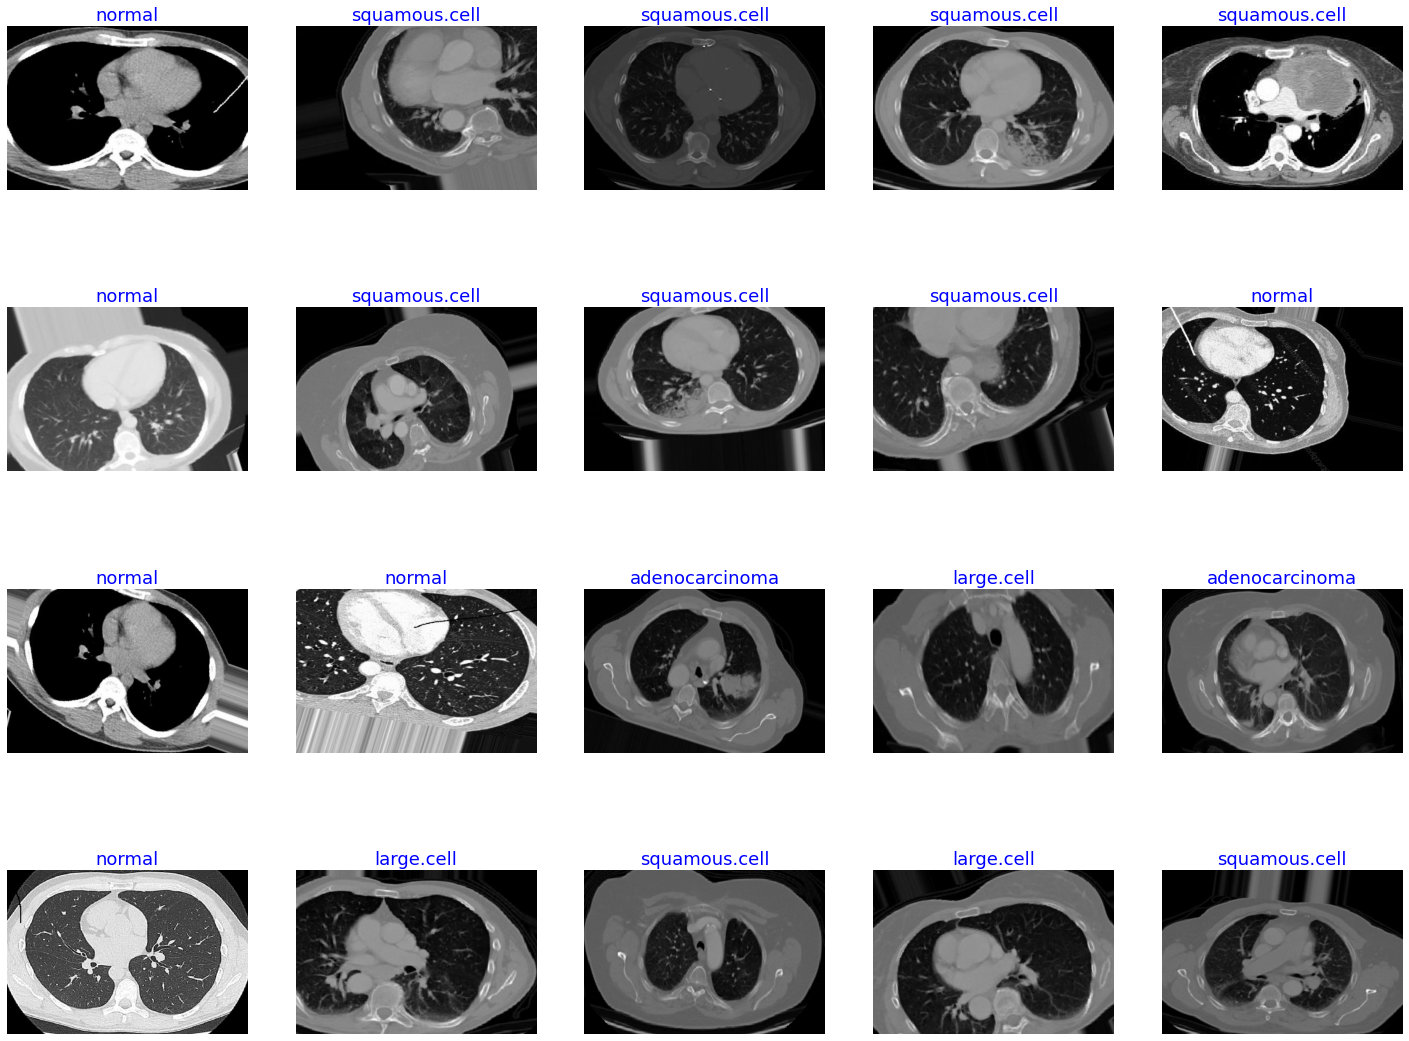

In [8]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) 
    plt.figure(figsize=(25, 25))
    length=len(labels)
    if length<25:  
        r=length
    else:
        r=25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image=images[i] /255       
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=18)
        plt.axis('off')
    plt.show()
    
show_image_samples(train_gen )

In [9]:
def make_model(img_size, lr, mod_num=3):  
    img_shape=(img_size[0], img_size[1], 3)
    if mod_num == 3:
        base_model=tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
        msg='Created EfficientNet B3 model'

   
    base_model.trainable=True
    x=base_model.output
    x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
    x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                    bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
    x=Dropout(rate=.4, seed=123)(x)       
    output=Dense(class_count, activation='softmax')(x)
    model=Model(inputs=base_model.input, outputs=output)
    model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy']) 
    msg=msg + f' with initial learning rate set to {lr}'
    print_in_color(msg)
    return model

lr=.001
model=make_model(img_size, lr) 

43950080/43941136 [==============================] - 1s 0us/step
Created EfficientNet B3 model with initial learning rate set to 0.001



In [10]:
class LR_ASK(keras.callbacks.Callback):
    def __init__ (self, model, epochs,  ask_epoch, dwell=True, factor=.4): 
        super(LR_ASK, self).__init__()
        self.model=model               
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        self.ask=True 
        self.lowest_vloss=np.inf
        self.lowest_aloss=np.inf
        self.best_weights=self.model.get_weights() 
        self.best_epoch=1
        self.plist=[]
        self.alist=[]
        self.dwell= dwell
        self.factor=factor
        
    def get_list(self): 
        return self.plist, self.alist
    def on_train_begin(self, logs=None): 
        if self.ask_epoch == 0: 
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs: 
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask=False 
        if self.epochs == 1:
            self.ask=False
        else:
            msg =f'Training will proceed until epoch {ask_epoch} then you will be asked to' 
            print_in_color(msg )
            msg='enter H to halt training or enter an integer for how many more epochs to run then be asked again'
            print_in_color(msg)
            if self.dwell:
                msg='learning rate will be automatically adjusted during training'
                print_in_color(msg, (0,255,0))
        self.start_time= time.time()
       
    def on_train_end(self, logs=None):  
        msg=f'loading model with weights from epoch {self.best_epoch}'
        print_in_color(msg, (0,255,255))
        self.model.set_weights(self.best_weights) 
        tr_duration=time.time() - self.start_time           
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print_in_color (msg) 
        
    def on_epoch_end(self, epoch, logs=None):  
        vloss=logs.get('val_loss')  
        aloss=logs.get('loss')
        if epoch >0:
            deltav = self.lowest_vloss- vloss 
            pimprov=(deltav/self.lowest_vloss) * 100 
            self.plist.append(pimprov)
            deltaa=self.lowest_aloss-aloss
            aimprov=(deltaa/self.lowest_aloss) * 100
            self.alist.append(aimprov)
        else:
            pimprov=0.0 
            aimprov=0.0
        if vloss< self.lowest_vloss:
            self.lowest_vloss=vloss
            self.best_weights=self.model.get_weights() 
            self.best_epoch=epoch + 1            
            msg=f'\n validation loss of {vloss:7.4f} is {pimprov:7.4f} % below lowest loss, saving weights from epoch {str(epoch + 1):3s} as best weights'
            print_in_color(msg, (0,255,0))
        else:
            pimprov=abs(pimprov)
            msg=f'\n validation loss of {vloss:7.4f} is {pimprov:7.4f} % above lowest loss of {self.lowest_vloss:7.4f} keeping weights from epoch {str(self.best_epoch)} as best weights'
            print_in_color(msg, (255,255,0)) 
            if self.dwell:
                lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) 
                new_lr=lr * self.factor
                msg=f'learning rate was automatically adjusted from {lr:8.6f} to {new_lr:8.6f}, model weights set to best weights'
                print_in_color(msg) 
                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) 
                self.model.set_weights(self.best_weights)      
                
        if aloss< self.lowest_aloss:
            self.lowest_aloss=aloss        
        if self.ask: 
            if epoch + 1 ==self.ask_epoch: 
                msg='\n Enter H to end training or  an integer for the number of additional epochs to run then ask again'
                print_in_color(msg) 
                ans=input()
                
                if ans == 'H' or ans =='h' or ans == '0': 
                    msg=f'you entered {ans},  Training halted on epoch {epoch+1} due to user input\n'
                    print_in_color(msg)
                    self.model.stop_training = True 
                else: 
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
                    else:
                        msg=f'you entered {ans} Training will continue to epoch {self.ask_epoch}'
                        print_in_color(msg) 
                        if self.dwell==False:
                            lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) 
                            msg=f'current LR is  {lr:8.6f}  hit enter to keep  this LR or enter a new LR'
                            print_in_color(msg) 
                            ans=input(' ')
                            if ans =='':
                                msg=f'keeping current LR of {lr:7.5f}'
                                print_in_color(msg) 
                            else:
                                new_lr=float(ans)
                                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) 
                                msg=f' changing LR to {ans}'
                                print_in_color(msg) 

<a id="callbacks"></a>
# <center>Instantiate custom callback 

In [11]:
epochs=40
ask_epoch=25
ask=LR_ASK(model, epochs,  ask_epoch)
callbacks=[ask]

In [12]:

history=model.fit(x=train_gen,   epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Training will proceed until epoch 25 then you will be asked to

enter H to halt training or enter an integer for how many more epochs to run then be asked again

learning rate will be automatically adjusted during training

Epoch 1/40
80/80 [==============================] - 114s 1s/step - loss: 8.0958 - accuracy: 0.6731 - val_loss: 7.7110 - val_accuracy: 0.6250

 validation loss of  7.7110 is  0.0000 % below lowest loss, saving weights from epoch 1   as best weights

Epoch 2/40
80/80 [==============================] - 81s 1s/step - loss: 6.1459 - accuracy: 0.9100 - val_loss: 5.9955 - val_accuracy: 0.7361

 validation loss of  5.9955 is 22.2469 % below lowest loss, saving weights from epoch 2   as best weights

Epoch 3/40
80/80 [==============================] - 81s 1s/step - loss: 5.0317 - accuracy: 0.9681 - val_loss: 4.8470 - val_accuracy: 0.8333

 validation loss of  4.8470 is 19.1560 % below lowest loss, saving weights from epoch 3   as best weights

Epoch 4/40
80/80 [=============

 H


you entered H,  Training halted on epoch 25 due to user input


loading model with weights from epoch 23

training elapsed time was 0.0 hours, 54.0 minutes, 48.37 seconds)



<a id="plot"></a>
# <center>Define a function to plot the training data

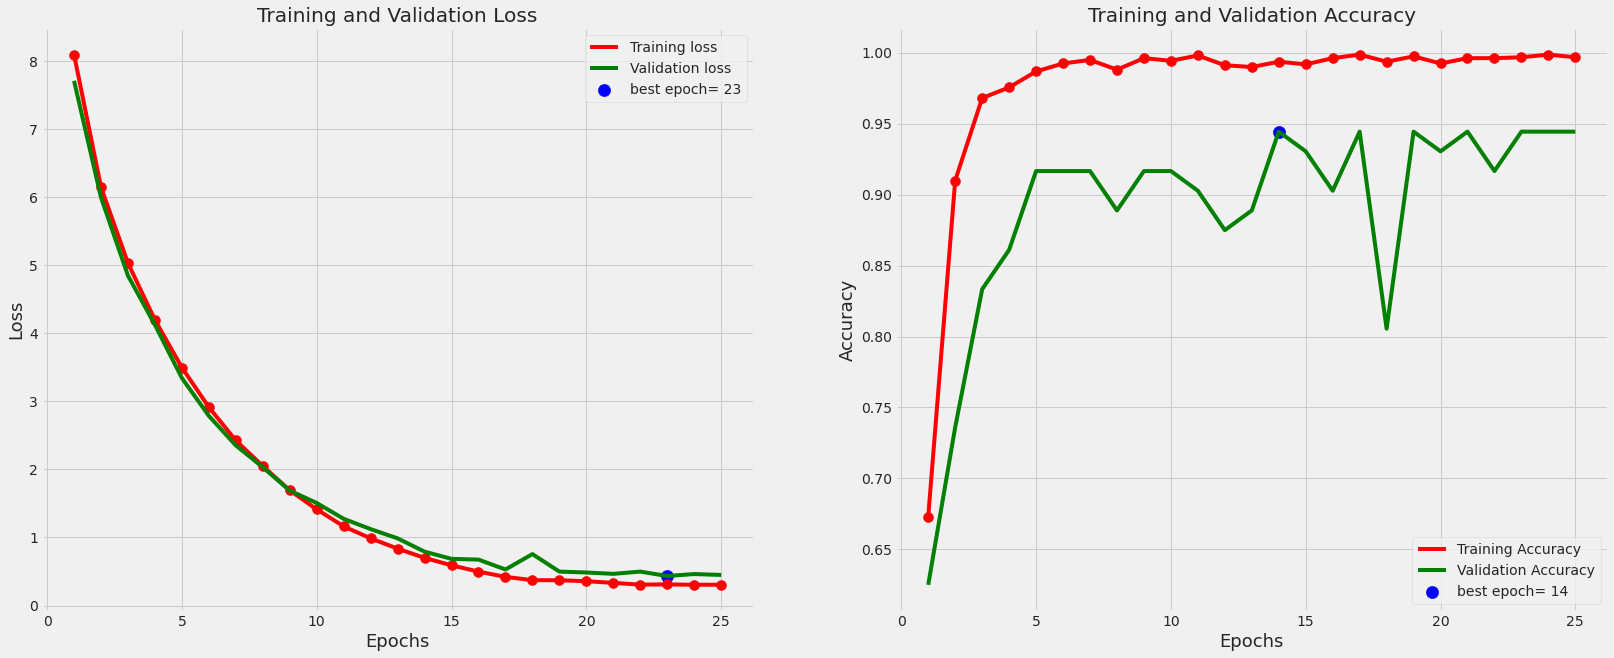

In [14]:
def tr_plot(tr_data, start_epoch):
    
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')    
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(25,10))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].scatter(Epochs, tloss, s=100, c='red')    
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=18)
    axes[0].set_ylabel('Loss', fontsize=18)
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].scatter(Epochs, tacc, s=100, c='red')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs', fontsize=18)
    axes[1].set_ylabel('Accuracy', fontsize=18)
    axes[1].legend()
    plt.tight_layout    
    plt.show()
    
    
tr_plot(history,0)

5/5 [==============================] - 8s 526ms/step
there were 18 errors in 315 tests for an accuracy of  94.29



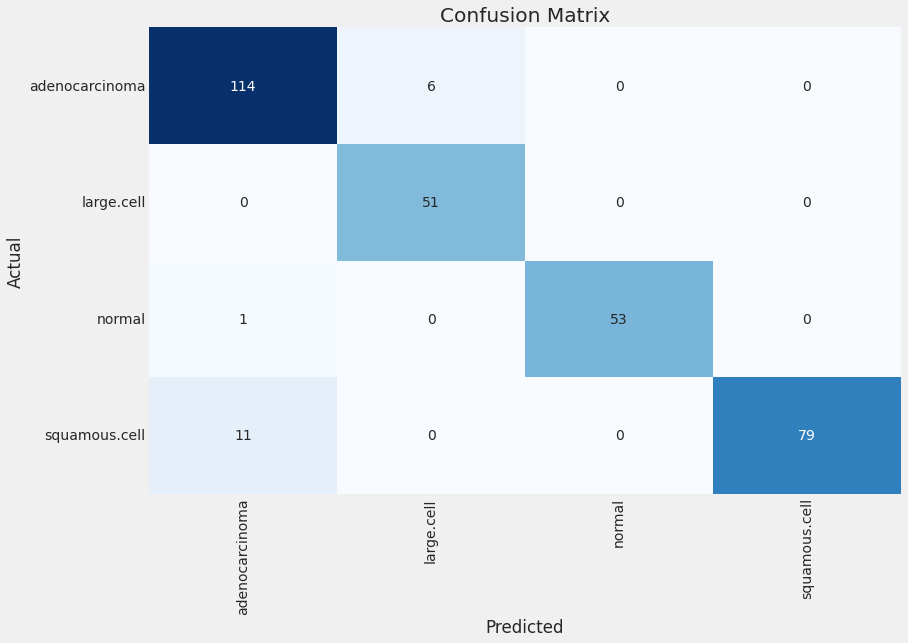

Classification Report:
----------------------
                 precision    recall  f1-score   support

adenocarcinoma     0.9048    0.9500    0.9268       120
    large.cell     0.8947    1.0000    0.9444        51
        normal     1.0000    0.9815    0.9907        54
 squamous.cell     1.0000    0.8778    0.9349        90

      accuracy                         0.9429       315
     macro avg     0.9499    0.9523    0.9492       315
  weighted avg     0.9467    0.9429    0.9429       315



In [15]:
def predictor(test_gen):    
    y_pred= []
    error_list=[]
    error_pred_list = []
    y_true=test_gen.labels
    classes=list(test_gen.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(test_gen, verbose=1)
    tests=len(preds)    
    for i, p in enumerate(preds):        
        pred_index=np.argmax(p)         
        true_index=test_gen.labels[i]        
        if pred_index != true_index:                                           
            errors=errors + 1
            file=test_gen.filenames[i]
            error_list.append(file)
            error_class=classes[pred_index]
            error_pred_list.append(error_class)
        y_pred.append(pred_index)
            
    acc=( 1-errors/tests) * 100
    msg=f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}'
    print_in_color(msg, (0,255,255), (100,100,100))
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    f1score=f1_score(ytrue, ypred, average='weighted')* 100
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
       
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4)
    print("Classification Report:\n----------------------\n", clr)
    return errors, tests, error_list, error_pred_list, f1score

errors, tests, error_list, error_pred_list, f1score =predictor(test_gen)

In [21]:
def print_errors(error_list):
    if len(error_list) == 0:
        print_in_color('There were no errors in predicting the test set')
    else:
        if len(error_list)<50:
            print ('Below is a list of test files that were miss classified \n')
            print ('{0:^30s}{1:^30s}'.format('Test File', ' Predicted as'))            
            for i in range(len(error_list)):
                fpath=error_list[i]        
                split=fpath.split('/')        
                f=split[4]+ '-' + split[5]
                print(f'{f:^30s}{error_pred_list[i]:^30s}')

In [17]:
print_errors(error_list)

In [16]:
def save_model(subject, classes, img_size, f1score, working_dir):
    name=subject + '-' + str(len(classes)) + '-(' + str(img_size[0]) + ' X ' + str(img_size[1]) + ')'
    save_id=f'{name}-{f1score:5.2f}.h5'
    model_save_loc=os.path.join(working_dir, save_id)
    model.save(model_save_loc)
    msg= f'model was saved as {model_save_loc}'
    print_in_color(msg, (0,255,255), (100,100,100)) 

In [17]:
working_dir=r'./'
subject='chest scans'
save_model(subject, classes, img_size, f1score, working_dir)

model was saved as ./chest scans-4-(300 X 440)-94.29.h5



In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 440, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 300, 440, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 300, 440, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 301, 441, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

In [19]:
model.save('MP')

In [20]:
!zip -r file.zip /kaggle/working/MP

  adding: kaggle/working/MP/ (stored 0%)
  adding: kaggle/working/MP/variables/ (stored 0%)
  adding: kaggle/working/MP/variables/variables.data-00000-of-00001 (deflated 9%)
  adding: kaggle/working/MP/variables/variables.index (deflated 79%)
  adding: kaggle/working/MP/saved_model.pb (deflated 92%)
  adding: kaggle/working/MP/assets/ (stored 0%)
  adding: kaggle/working/MP/keras_metadata.pb (deflated 96%)


In [21]:
model.layers

In [22]:
len(model.layers)

389

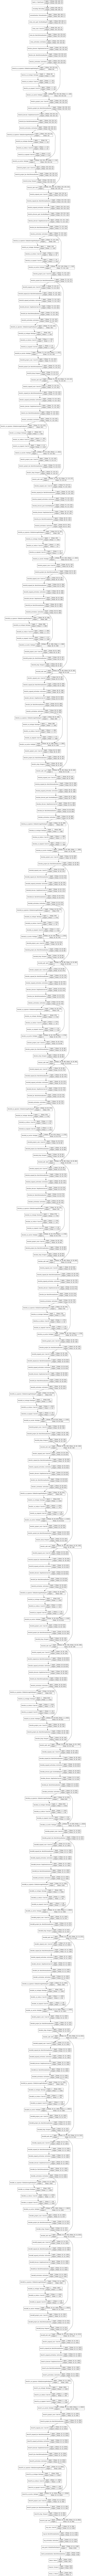

In [26]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='layers_plot.png', show_shapes=True, show_layer_names=True)